# Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [5]:
df = pd.read_csv("./uber.csv")

# Display dataset information

In [6]:
print("Dataset Information:\n")
print(df.info())
print("\nDataset Head:\n")
print(df.head())

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None

Dataset Head:

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3

# 1. Pre-processing the dataset


Convert 'pickup_datetime' to datetime

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

Drop rows with missing values in 'pickup_datetime' and 'fare_amount'

In [8]:
df.dropna(subset=['pickup_datetime', 'fare_amount'], inplace=True)

Remove negative and extremely high values in 'fare_amount' and 'passenger_count'

In [9]:
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

In [10]:
print(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].isnull().sum())

pickup_latitude      0
pickup_longitude     0
dropoff_latitude     0
dropoff_longitude    0
dtype: int64


In [11]:
invalid_rows = df[
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90) |
    (df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180)
]
print(invalid_rows)

        Unnamed: 0                            key  fare_amount  \
4949      42931506  2012-04-28 00:58:00.000000235          4.9   
32549      5634081   2012-06-16 10:04:00.00000061         15.7   
48506      1055960  2011-11-05 23:26:00.000000309         33.7   
56617     14257861   2012-03-11 07:24:00.00000031          8.1   
61793      2849369    2012-06-13 05:45:00.0000006          8.5   
75851     33249845   2011-11-05 00:22:00.00000051         15.7   
91422     23566642  2011-05-18 13:24:00.000000213         16.1   
103745    16826862  2011-10-14 19:04:00.000000202         12.9   
139447    39981694   2012-01-20 11:50:00.00000088         13.7   
144253     9421322   2009-08-26 11:55:00.00000023          7.3   
161652    25264921   2010-05-12 12:19:00.00000098          4.1   
199936    44787414   2012-07-21 16:19:00.00000099          4.1   

                 pickup_datetime  pickup_longitude  pickup_latitude  \
4949   2012-04-28 00:58:00+00:00       -748.016667        40.739957   

Define latitude and longitude bounds

In [12]:
lat_min, lat_max = -90.0, 90.0
lon_min, lon_max = -90.0, 90.0

Use median or mean for replacing outliers

In [13]:
df['pickup_longitude'] = df['pickup_longitude'].apply(lambda x: x if lon_min <= x <= lon_max else df['pickup_longitude'].median())
df['pickup_latitude'] = df['pickup_latitude'].apply(lambda x: x if lat_min <= x <= lat_max else df['pickup_latitude'].median())
df['dropoff_longitude'] = df['dropoff_longitude'].apply(lambda x: x if lon_min <= x <= lon_max else df['dropoff_longitude'].median())
df['dropoff_latitude'] = df['dropoff_latitude'].apply(lambda x: x if lat_min <= x <= lat_max else df['dropoff_latitude'].median())

In [14]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1


Calculate distance between pickup and dropoff points using geopy

In [15]:
def calculate_distance(row):
    try:
        return geodesic(
            (row['pickup_latitude'], row['pickup_longitude']),
            (row['dropoff_latitude'], row['dropoff_longitude'])
        ).km
    except ValueError as e:
        print(f"Error calculating distance for row {row.name}: {e}")
        return None  # or 0, depending on how you want to handle errors

df['distance_km'] = df.apply(calculate_distance, axis=1)


Drop rows with zero or very high distances

In [16]:
df = df[df['distance_km'] > 0]
df = df[df['distance_km'] < 100]

Extract date and time features from 'pickup_datetime'

In [17]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_year'] = df['pickup_datetime'].dt.year

Drop unnecessary columns

In [18]:
df.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)


In [19]:
df

,Unnamed: 0,fare_amount,passenger_count,distance_km,pickup_hour,pickup_day,pickup_month,pickup_year
0,24238194,7.5,1,1.681111,19,7,5,2015
1,27835199,7.7,1,2.454363,20,17,7,2009
2,44984355,12.9,1,5.039603,21,24,8,2009
3,25894730,5.3,3,1.661442,8,26,6,2009
4,17610152,16.0,5,4.483730,17,28,8,2014
...,...,...,...,...,...,...,...,...
199995,42598914,3.0,1,0.112128,10,28,10,2012
199996,16382965,7.5,1,1.879635,1,14,3,2014
199997,27804658,30.9,2,12.867916,0,29,6,2009
199998,20259894,14.5,1,3.536552,14,20,5,2015


# 2. Identify outliers

Visualize 'fare_amount' and 'distance_km' distributions

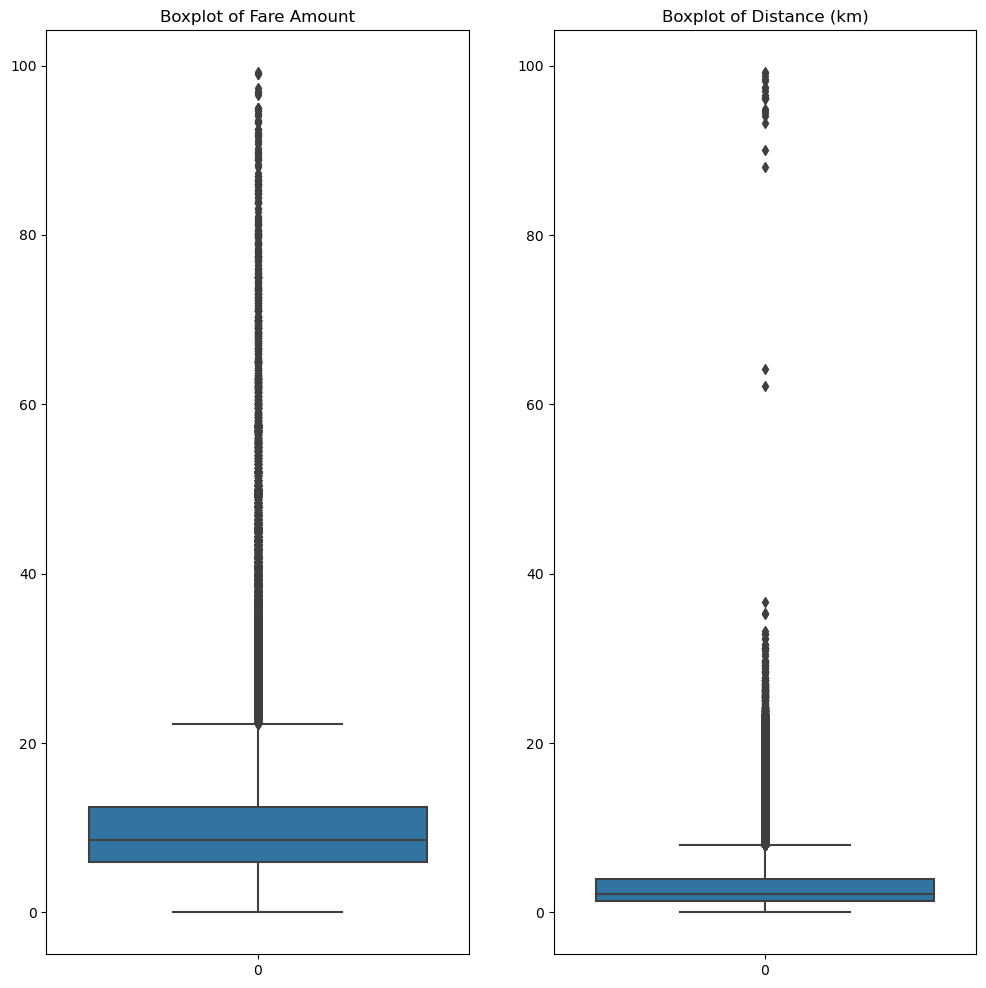

In [20]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
sns.boxplot(df['fare_amount'])
plt.title('Boxplot of Fare Amount')
plt.subplot(1, 2, 2)
sns.boxplot(df['distance_km'])
plt.title('Boxplot of Distance (km)')
plt.show()

Remove outliers based on z-scores for 'fare_amount' and 'distance_km'

In [21]:
from scipy import stats
df = df[(np.abs(stats.zscore(df[['fare_amount', 'distance_km']])) < 3).all(axis=1)]

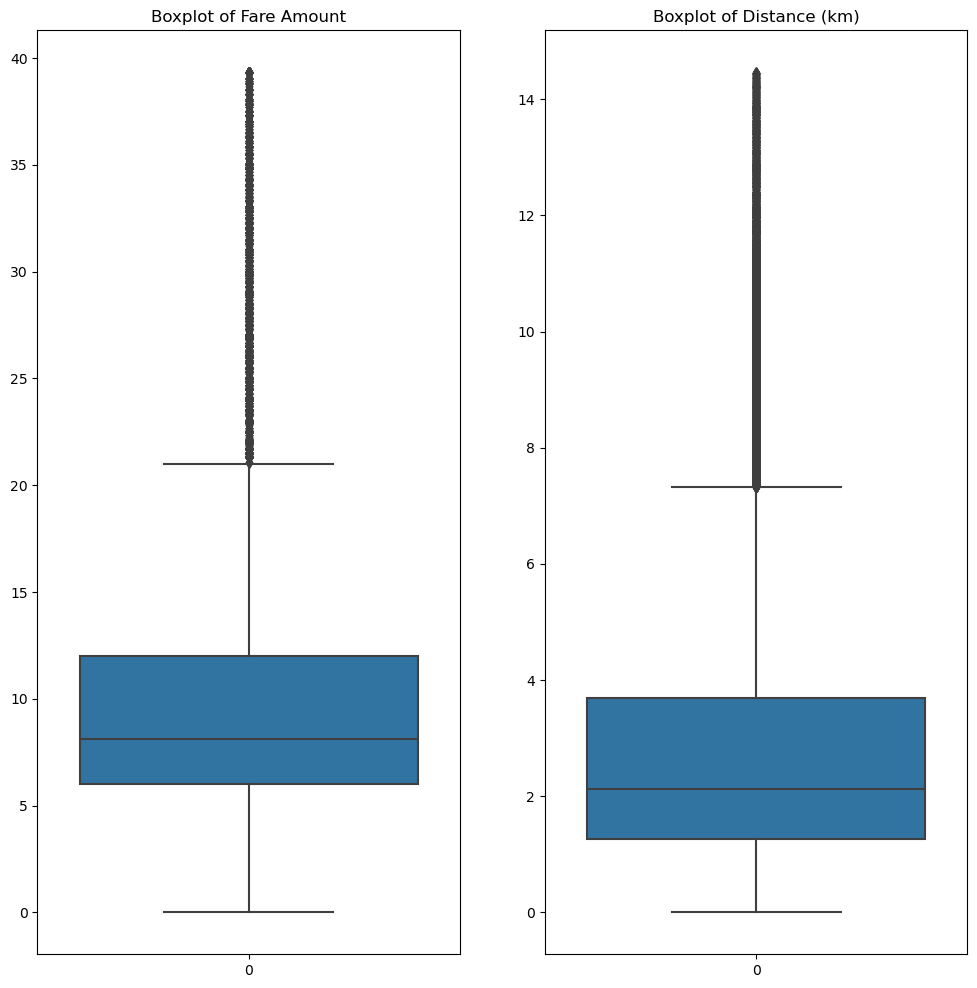

In [22]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
sns.boxplot(df['fare_amount'])
plt.title('Boxplot of Fare Amount')
plt.subplot(1, 2, 2)
sns.boxplot(df['distance_km'])
plt.title('Boxplot of Distance (km)')
plt.show()

# 3. Check correlation

Plot correlation heatmap

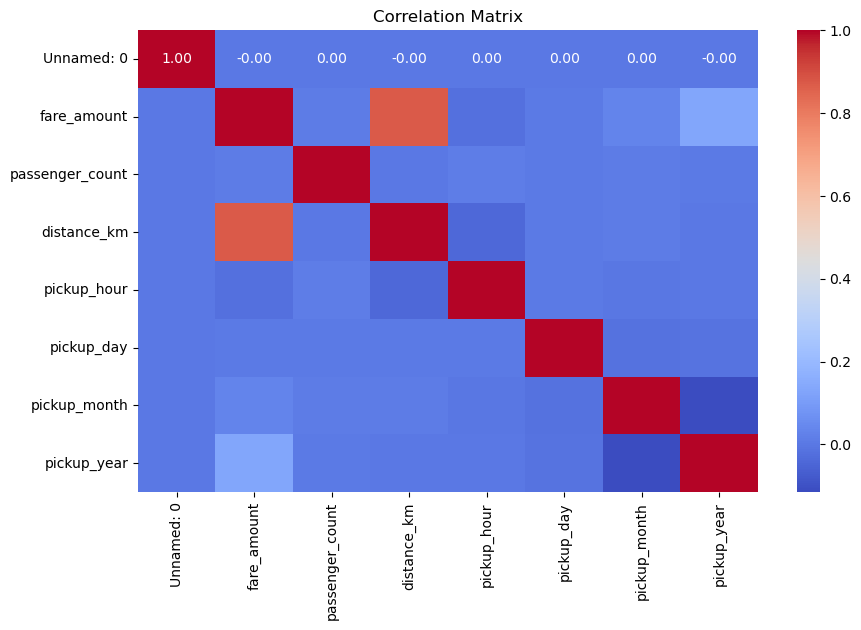

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 4. Implement Linear Regression and Random Forest Regression models

Define features and target variable

In [24]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

# Split data into training and testing sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Initialize and train the Linear Regression model


In [26]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

Initialize and train the Random Forest Regression model

In [27]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

Predict on test set

In [28]:
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)

Calculate evaluation metrics

In [29]:
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

# Linear Regression evaluation

In [30]:
r2_linear, rmse_linear = evaluate_model(y_test, y_pred_linear)
print("Linear Regression:")
print(f"R^2 Score: {r2_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")

Linear Regression:
R^2 Score: 0.7740
RMSE: 2.9062


# Random Forest Regression evaluation

In [31]:
r2_rf, rmse_rf = evaluate_model(y_test, y_pred_rf)
print("\nRandom Forest Regression:")
print(f"R^2 Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


Random Forest Regression:
R^2 Score: 0.7957
RMSE: 2.7633


Visualization of predicted vs actual fare amount for both models

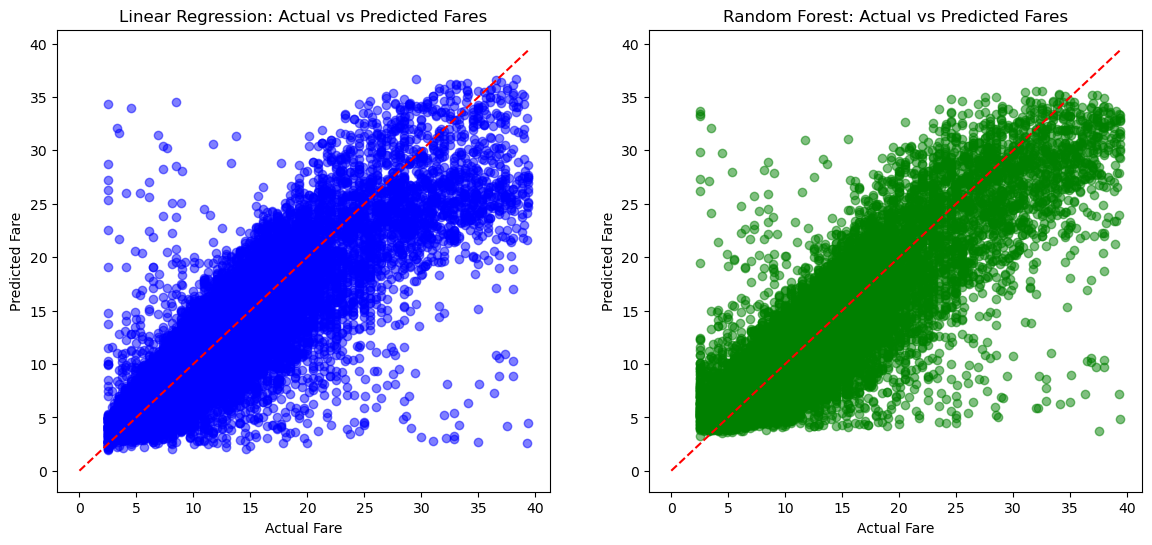

In [32]:
plt.figure(figsize=(14, 6))
# Linear Regression Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Linear Regression: Actual vs Predicted Fares")

# Random Forest Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Random Forest: Actual vs Predicted Fares")

plt.show()

Bar plot of R2 and RMSE comparison

In [33]:
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R^2 Score': [r2_linear, r2_rf],
    'RMSE': [rmse_linear, rmse_rf]
})

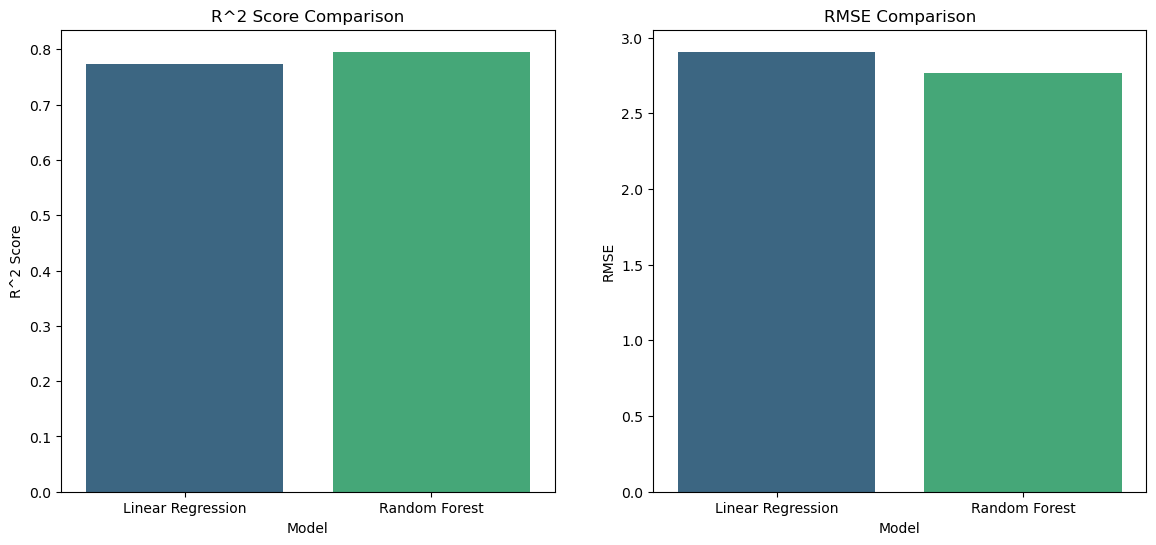

In [34]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R^2 Score', data=metrics, palette='viridis')
plt.title("R^2 Score Comparison")

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=metrics, palette='viridis')
plt.title("RMSE Comparison")
plt.show()

In [35]:
solution= df.copy()

In [36]:
solution["LinerPred"]=linear_model.predict(df.drop('fare_amount', axis=1))

In [37]:
solution["RandomForestPred"]=random_forest_model.predict(df.drop('fare_amount', axis=1))

In [38]:
solution

,Unnamed: 0,fare_amount,passenger_count,distance_km,pickup_hour,pickup_day,pickup_month,pickup_year,LinerPred,RandomForestPred
0,24238194,7.5,1,1.681111,19,7,5,2015,8.769105,7.7900
1,27835199,7.7,1,2.454363,20,17,7,2009,7.960592,8.0280
2,44984355,12.9,1,5.039603,21,24,8,2009,13.777405,12.5460
3,25894730,5.3,3,1.661442,8,26,6,2009,6.060768,5.7120
4,17610152,16.0,5,4.483730,17,28,8,2014,14.886667,16.0100
...,...,...,...,...,...,...,...,...,...,...
199995,42598914,3.0,1,0.112128,10,28,10,2012,4.158609,3.5680
199996,16382965,7.5,1,1.879635,1,14,3,2014,8.395008,7.3700
199997,27804658,30.9,2,12.867916,0,29,6,2009,30.787404,29.0481
199998,20259894,14.5,1,3.536552,14,20,5,2015,12.822418,13.8050
